### Edge elements on triangles
This is based on $2 \times 2$-element resonator example from "Computational Electromagnetics", 2000
but solved with code from Davidson ("Computational Electromagnetics for RF and Microwave Engineering", 2011)

In [73]:
# helper functions
using LinearAlgebra
include("whitney.jl")
include("meshing.jl")
include("distmesh-julia/test.jl")
nothing

In [74]:
function SandT(x1, y1, x2, y2, x3, y3)
    global LOCALEDGENODES

    area = .5abs(det([1. x1 y1
                      1. x2 y2
                      1. x3 y3]))
    temp = inv([x1 x2 x3
                y1 y2 y3
                1. 1. 1.])
    b = temp[:,1]
    c = temp[:,2]
    a = temp[:,3]
    ∇λ = [[b[1], c[1]],
          [b[2], c[2]],
          [b[3], c[3]]]
    φ = zeros(3, 3) # φij = ∇λi ⋅ ∇λj = (bi⋅ci + bj⋅cj)
    v = zeros(3, 3) # vij = ∇λi × ∇λj = (bi⋅cj - bj⋅ci)ẑ
    for ii = 1:3
       for jj = 1:3
           φ[ii, jj] = b[ii] * b[jj] + c[ii] * c[jj]
           v[ii, jj] = b[ii] * c[jj] - b[jj] * c[ii]
       end 
    end

    M = [2. 1. 1.
         1. 2. 1.
         1. 1. 2.] / 12.0

    # Compute S and T
    S = zeros(3, 3)
    T = zeros(3, 3)
    for ii = 1:3
       for jj = 1:3
         i1 = LOCALEDGENODES[ii,1]
         i2 = LOCALEDGENODES[ii,2]
         j1 = LOCALEDGENODES[jj,1]
         j2 = LOCALEDGENODES[jj,2]
         S[ii,jj] = 4area*v[i1, i2] * v[j1, j2]
         T[ii,jj] = area*(φ[i2, j2] * M[i1, j1] +
                        - φ[i2, j1] * M[i1, j2] +
                        - φ[i1, j2] * M[i2, j1] +
                        + φ[i1, j1] * M[i2, j2])
       end 
    end
    
    return S, T
end

SandT (generic function with 1 method)

In [75]:
function simplex2D(elem_num, xp, yp)
    global ELEMENTS
    global NODE_COORD 

    trinodes = ELEMENTS[elem_num, :]; 
    x1 = NODE_COORD[trinodes[1],1];
    y1 = NODE_COORD[trinodes[1],2];
    x2 = NODE_COORD[trinodes[2],1];
    y2 = NODE_COORD[trinodes[2],2];
    x3 = NODE_COORD[trinodes[3],1];
    y3 = NODE_COORD[trinodes[3],2];

    σ0 = det([1. x1 y1; 1. x2 y2; 1. x3 y3]);
    σ1 = det([1. xp yp; 1. x2 y2; 1. x3 y3]);
    σ2 = det([1. x1 y1; 1. xp yp; 1. x3 y3]);
    σ3 = det([1. x1 y1; 1. x2 y2; 1. xp yp]);
    λ  = [σ1/σ0, σ2/σ0, σ3/σ0]
    return λ
end

simplex2D (generic function with 1 method)

In [76]:
# Parameters
ε0 = 1.
μ0 = 1.
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr

a, b = 1.3, 0.9
n, m = 13, 9
nothing

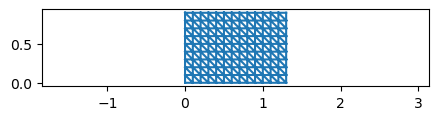

In [6]:
using PyPlot

a, b = 1.3, 0.9
n, m = 13, 9
LOCALEDGENODES = [1 2; 1 3; 2 3]
trimesh(a, b, n, m)
triedgemake()

figure(figsize=(5,1))
triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
axis("equal");

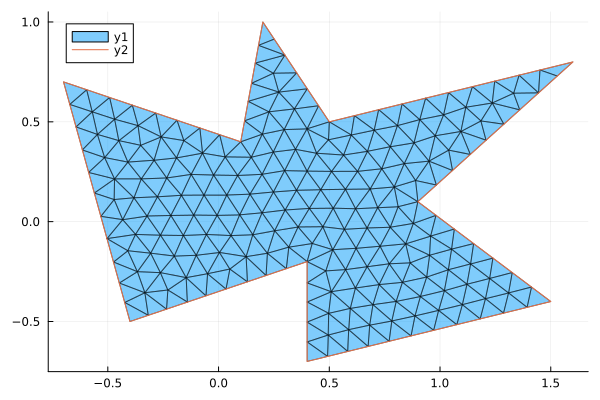

In [143]:
import Plots
pv = [-0.4 -0.5;0.4 -0.2;0.4 -0.7;1.5 -0.4;0.9 0.1;
      1.6 0.8;0.5 0.5;0.2 1;0.1 0.4;-0.7 0.7;-0.4 -0.5]
fd = p -> dpolygon( p, pv )
fh = p -> ones(size(p,1))
h0=0.1
bbox=[-1 -1;2 1]
p_fix=pv
e_fix=[]
it_max=2000
(p, t) = distmesh( fd, fh, h0, bbox, p_fix, e_fix, it_max )
x = pv[:,1]
y = pv[:,2]
plotgrid( p, t )                                                        
# # y = fd(x)
Plots.plot!(x, y)
# scatter!(p[:,1], p[:,2],markersize=1)
# # scatter!(p[:,1], p[:,2])
# # pv[:,1]

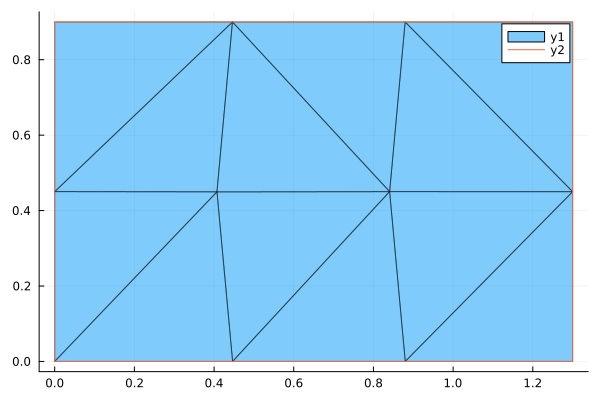

In [94]:
# using PyPlot

a, b = 1.3, 0.9

pv = [0 0; a 0; a b; 0 b; 0 0]
fd = p -> dpolygon( p, pv )
fh = p -> ones(size(p,1))
h0=0.45
bbox=[0 0;a b]
p_fix=pv
e_fix=[]
it_max=1000
(p, t) = distmesh( fd, fh, h0, bbox, p_fix, e_fix, it_max )
x = pv[:,1]
y = pv[:,2]
plotgrid( p, t )                                                        
# # y = fd(x)
Plots.plot!(x, y)


# a, b = 1.3, 0.9
# n, m = 13, 9
# LOCALEDGENODES = [1 2; 1 3; 2 3]
# trimesh(a, b, n, m)
# triedgemake()

# figure(figsize=(5,1))
# triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
# axis("equal");

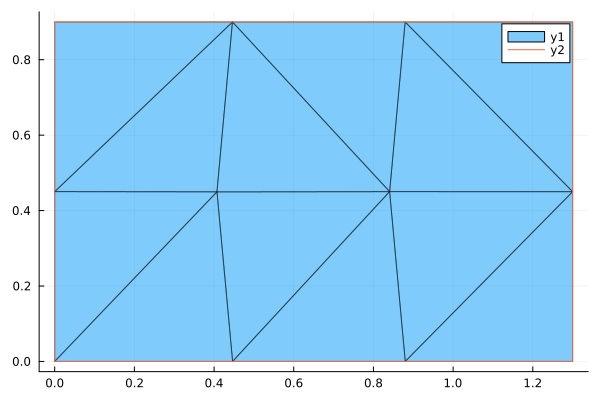

In [95]:
epsilon = 0.001
# bottom_row_points
p[p[:, 1] .< epsilon, 1] .= 0
# top_row_points
p[p[:, 2] .> b - epsilon, 2] .= b
# left_column_points
p[p[:, 2] .< epsilon, 2] .= 0
# right_column_points
p[p[:, 1] .> a - epsilon, 1] .= a


plotgrid( p, t )                                                        
# # y = fd(x)
Plots.plot!(x, y)

In [96]:
# map distmesh results to correct format

NODE_COORD = p
ELEMENTS = t
NUM_NODES = size(NODE_COORD, 1)
NUM_ELEMS = size(ELEMENTS, 1)
LOCALEDGENODES = [1 2; 1 3; 2 3];
triedgemake()
# sets:
# EDGES
# NODE_EDGES
# ELEMENT_EDGES
# NUM_EDGES

In [97]:
DOF_NONE = 0
DOF_PEC  = 1

function dof_type(a, b)
    global NUM_EDGES
    global EDGES
    global NODE_COORD
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
       node1 = EDGES[i_edge, 1]
       node2 = EDGES[i_edge, 2]
       if NODE_COORD[node1, 2] ≈ 0. && NODE_COORD[node2, 2] ≈ 0. # ie y=0
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 2] ≈ b  && NODE_COORD[node2, 2] ≈ b  # ie y=b
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ 0. && NODE_COORD[node2, 1] ≈ 0. # ie x=0
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ a  && NODE_COORD[node2, 1] ≈ a  # ie x=a
           dof_flag[i_edge] = DOF_PEC
       end
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [98]:
function dof_renumber!(dof, Γ)
    global NUM_EDGES
    global NUM_DOFS
    last = 0
    for i_edge = 1:NUM_EDGES
       if Γ[i_edge] == 0
         dof[i_edge] = last + 1
         last += 1
       else
         dof[i_edge] = 0
       end
    end
    NUM_DOFS = last
    return dof
end

dof_renumber! (generic function with 1 method)

In [99]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(a, b)
dof_renumber!(dof, Γ);

In [100]:
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = zeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
T = zeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ

# NODE_COORD - współrzędne wszystkich punktów z których zbudowane są trójkąty (a być może po prosty figura?)
# ELEMENTS - numery punktów z których zbudowane są trójkąty
# NUM_ELEMS - liczba trójkątów

for ielem = 1:NUM_ELEMS # Assemble by elements
  trinodes = ELEMENTS[ielem, :]
  Se, Te = SandT(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                 NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                 NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
  
  for jedge = 1:3
    jj = dof[ELEMENT_EDGES[ielem, jedge]]
    if jj == 0 continue end
    for kedge = 1:3
      kk = dof[ELEMENT_EDGES[ielem, kedge]]
      if kk == 0 continue end
      S[jj, kk] = S[jj, kk] + (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + (μ0*ε) * Te[jedge, kedge]
    end
  end
end

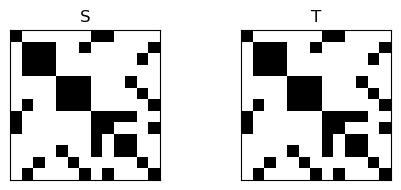

In [101]:
using PyPlot
figure(figsize=(5, 2))
subplot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

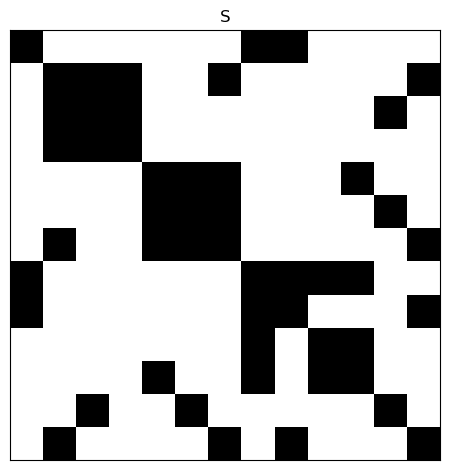

In [102]:
using PyPlot
# figure(figsize=(5, 2))
plot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
# subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

In [103]:
using LinearAlgebra

k², e = eigen(S, T)

speed_of_light = 299_792_458.
for n in 1:length(k²)
    wavenumber_squared = k²[n]
    if imag(wavenumber_squared) ≈ 0.0
        if real(wavenumber_squared) > 0.0
            frequency = sqrt(abs(wavenumber_squared)) / 2π * speed_of_light
            println(n, ". ", 1e-6frequency, "MHz")
            #if 114e6 < frequency < 116e6
            #    println(n, ". ", 1e-6frequency, "MHz")
            #end
        end
    end
end

1. 1.9909688077372128e-7MHz
2. 2.6936025033240378e-6MHz
3. 113.2928309134538MHz
4. 162.0181292312346MHz
5. 201.51968954318437MHz
6. 216.89335882102085MHz
7. 277.1500401960367MHz
8. 375.5425073235269MHz
9. 387.9169636516992MHz
10. 428.03111600791965MHz
11. 482.94839736013773MHz
12. 518.1673949227709MHz
13. 560.9821418877497MHz


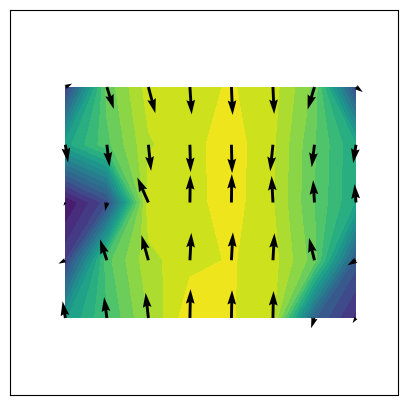

In [104]:
n = 3
x = 0.1:0.15:1.2
y = 0.1:0.15:0.8
E = evaluate(WhitneyTriangleElement(), e[:, n], dof, x, y)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx = [x for _ in y, x in x]
yy = [y for y in y, _ in x]

figure(figsize=(5, 5))
contourf(xx', yy', normE, levels=20)
quiver(xx', yy', E[:, :, 1], E[:, :, 2])
xlim([-0.1, +1.3])
ylim([-0.1, +0.9])
 xticks([]); yticks([]);